In [1]:
import os

# The notebook is a subfolder, must go back to parent folder
# Note that if if cell is executed twice, the remaining cells
# will fail because the current working directory will be wrong
os.chdir("..")

In [2]:
from src.vectorize import EmbeddingsModel
from tqdm import tqdm
import numpy as np
from pattern.text.en import parse
import pandas as pd
import jsbeautifier
from src.scrape import *


# Part I: Identify a few games

With word embeddings, a lot of games can be found automatically. 
However, before doing so, we need to identify some games first (we will assume we know none of the games that are being reviewed).

In [3]:
scrape_games = True
if scrape_games:
    look_for_words()
    unique_words()
    words_abbreviation()
    count_words()


Finding games...


# Part II: Create a dataframe

All the relevant information within the json file will be organised into a well-organised pandas DataFrame to make all subsequent steps easier.

The Dataframe will be saved as a csv file which can be reloaded later to accelerate the process. 

The following step needs only to be done once per corpus

In [4]:
make_csv = False
if make_csv:
    build_dataframe(get_more_infos=True)
    normalize_csv(spell_check=True)
    get_word2vec_vocab()
    normalize_csv_for_word2vec()

### Find The most mentionned games among the ones that were found

In [5]:
scraped_games = pd.read_table("extracted/lists/game_lines.csv", sep='[')
scraped_games.columns = ["Game", "mentions"]
games = np.array(scraped_games["Game"])
games = np.array([g.strip(",") for g in games])
scraped_games["Game"] = games

new_df = pd.DataFrame(index=games, data=np.array([None for _ in games]).reshape(-1, 1), columns=["n_mentions"])
for i, key in enumerate(range(len(scraped_games["Game"]))):
    new_df["n_mentions"][i] = len(scraped_games["mentions"][i].split(","))
# There is some noise: The Game, Well There, The Launcher et Now 
# Insurgency Really is about a game called Insurgency

new_df = new_df.sort_values(by=['n_mentions'], ascending=False)
new_df

,n_mentions
Team Fortress 2,251
Nuclear Throne,232
Dont Starve,86
Dota 2,79
Insurgency Really,65
Portal,51
Sonic Generations,49
Counter Strike Global Offensive,43
Well There,36
The Culling,27


In [55]:
print(parse("Dota_2"))
print(parse("dota"))
print(parse("dota 2"))
print(parse("Dota"))
print(parse("dota_2"))

Dota_2/NNP/B-NP/O
dota/NN/B-NP/O
dota/NN/B-NP/O 2/IN/B-PP/O
Dota/NNP/B-NP/O
dota_2/NN/B-NP/O


# Part III: Identify word embeddings (word2vec)


In [6]:
my_model = EmbeddingsModel()
train = False
direc = "saved_models/gensim_model"
model_name = "pretrained_GoogleNews-vectors-negative300"
checkpoint_fname = "steam_australia_norm_w2v"
chechpoint_path = "{}/{}".format(direc, model_name)
if train:
    my_model.train(checkpoint_fname + ".csv", checkpoint=chechpoint_path)
    my_model.save_model(checkpoint)
my_model.load_model("{}/{}.model".format(chechpoint_path, checkpoint_fname))

2019-12-19 02:50:50,186 : INFO : loading Word2Vec object from saved_models/gensim_model/pretrained_GoogleNews-vectors-negative300/steam_australia_norm_w2v.model
2019-12-19 02:50:50,475 : INFO : loading wv recursively from saved_models/gensim_model/pretrained_GoogleNews-vectors-negative300/steam_australia_norm_w2v.model.wv.* with mmap=None
2019-12-19 02:50:50,476 : INFO : setting ignored attribute vectors_norm to None
2019-12-19 02:50:50,477 : INFO : loading vocabulary recursively from saved_models/gensim_model/pretrained_GoogleNews-vectors-negative300/steam_australia_norm_w2v.model.vocabulary.* with mmap=None
2019-12-19 02:50:50,479 : INFO : loading trainables recursively from saved_models/gensim_model/pretrained_GoogleNews-vectors-negative300/steam_australia_norm_w2v.model.trainables.* with mmap=None
2019-12-19 02:50:50,480 : INFO : setting ignored attribute cum_table to None
2019-12-19 02:50:50,481 : INFO : loaded saved_models/gensim_model/pretrained_GoogleNews-vectors-negative300/st

In [50]:
tops_games = {
    'Super_Meat_Boy': None,
    'Team_Fortress_2': None,
    'Portal': None,
    'Men_Of_War': None,
    'Dont_Starve': None,
    'Nuclear_Throne': None,
}
for top in tops_games:
    tops_games[top] = my_model.model.most_similar(top, topn=100)
    tops_games[top] = pd.DataFrame(tops_games[top], columns=["word", "similarity"])

In [51]:
tops_games['Men_Of_War'][:20]

,word,similarity
0,Assault_Squad,0.409836
1,Honor_Airborne,0.314158
2,geier,0.313878
3,corbina,0.313584
4,prepreg,0.309638
5,oilholes,0.297793
6,Dragon_Ball,0.296060
7,fiel,0.292757
8,Tom_Clancy,0.292476
9,worldwide,0.290360


In [9]:
tops_games['Dont_Starve'][:20]

,word,similarity
0,ark,0.286986
1,runecraft,0.256924
2,Survival_Horror,0.241088
3,essence,0.238368
4,survival,0.232067
5,roselite,0.229331
6,mashed,0.224747
7,Terraria,0.223980
8,blacklight,0.220893
9,aspect,0.219792


In [10]:
tops_games['Team_Fortress_2'][:20]

,word,similarity
0,tfc,0.466157
1,cso,0.408814
2,deota,0.365959
3,Team_Fortress,0.322464
4,Counter_Strike_Global_Offensive,0.290620
5,First_Person_Shooter,0.289384
6,source,0.287115
7,fistful,0.284603
8,offensive,0.282172
9,Dirty_Bomb,0.276816


In [12]:
# For some reason, parse doesn't work the first few times
parse("spark")

RuntimeError: generator raised StopIteration

In [13]:
tops_nn = {
    'game': None,
    'games': None,
    'mode': None,
    'modes': None,
    'collection': None,
    'description': None,
    'experience': None,
    'category': None,
    'genre': None,
    'genres': None,
    'characteristics': None,
    'aspects': None,
    'features': None,   # GOOD ONE FOR 2- identify aspects (features) of a game
    'feature': None,
    'mechanics': None,
    'style': None,
    'cool': None,
    'awesome': None,
    'boring': None,
    'soundtrack': None,
    'elements': None,
    'storyline': None,
    'graphics': None,
    'graphic': None,
    'developer': None,
    'developers': None,
    'artwork': None,
    'music': None,
    'sound': None,
}
for top in tops_nn:
    tops_nn[top] = my_model.model.most_similar(top, topn=100)
    top_words = np.array(tops_nn[top])[:, 0].tolist()
    scores = np.array(tops_nn[top])[:, 1].tolist()
    top_words = [parse(str(k) + "\n") for k in top_words]
    top_nn_indices = [i for i, x in enumerate(top_words) if x.split("/")[1] in ["NN", "NNS"] and x.split("/")[0].lower() == x.split("/")[0]]

    top_words = np.concatenate((np.array([top_words[i].split("/")[0] for i in top_nn_indices]).reshape(-1, 1), 
                                np.array([np.round(float(scores[i]), 3) for i in top_nn_indices]).reshape(-1, 1)), 1)
    tops_nn[top] = pd.DataFrame(top_words, columns=["word", "similarity"])

In [14]:
tops_nn['game'][:20]

,word,similarity
0,games,0.519
1,experience,0.415
2,title,0.403
3,story,0.375
4,gambit,0.372
5,i,0.37
6,fun,0.356
7,dlc,0.356
8,review,0.35
9,time,0.329


In [15]:
tops_nn['games'][:20]

,word,similarity
0,titles,0.584
1,shooters,0.54
2,game,0.519
3,rgs,0.462
4,fpsps,0.447
5,moas,0.384
6,morphs,0.365
7,ones,0.358
8,things,0.353
9,sims,0.349


In [16]:
tops_nn['mode'][:20]

,word,similarity
0,modes,0.345
1,campaign,0.331
2,gamelote,0.312
3,coop,0.298
4,feature,0.27
5,pvp,0.267
6,option,0.262
7,mission,0.253
8,deathwatch,0.252
9,bots,0.244


In [17]:
tops_nn['mechanics'][:20]

,word,similarity
0,elements,0.482
1,controls,0.445
2,graphics,0.414
3,aspects,0.411
4,features,0.396
5,animations,0.372
6,concepts,0.344
7,puzzles,0.34
8,visuals,0.339
9,mechanic,0.338


In [18]:
tops_nn['features'][:20]

,word,similarity
0,elements,0.468
1,aspects,0.434
2,content,0.423
3,additions,0.4
4,mechanics,0.396
5,things,0.393
6,modes,0.375
7,functionality,0.374
8,updates,0.371
9,maps,0.366


In [19]:
tops_nn['music'][:10]

,word,similarity
0,soundtrack,0.58
1,sound,0.424
2,atmosphere,0.42
3,story,0.414
4,soothing,0.414
5,artwork,0.403
6,tunes,0.364
7,storyline,0.346
8,combat,0.342
9,mood,0.334


In [20]:
tops_nn['developers'][:10]

,word,similarity
0,devs,0.67
1,developer,0.467
2,creators,0.393
3,dev,0.366
4,valve,0.353
5,studios,0.348
6,people,0.327
7,bethesda,0.319
8,makers,0.312
9,updates,0.307


In [21]:
tops_nn['graphics'][:10]

,word,similarity
0,visuals,0.58
1,controls,0.416
2,mechanics,0.414
3,environments,0.405
4,textures,0.395
5,animations,0.367
6,physics,0.357
7,artwork,0.357
8,traffics,0.348
9,music,0.332


In [22]:
tops_nn['soundtrack'][:10]

,word,similarity
0,music,0.58
1,story,0.421
2,artwork,0.364
3,visuals,0.363
4,storyline,0.356
5,soothing,0.344
6,scenery,0.333
7,narration,0.319
8,combat,0.314
9,graphics,0.304


# Identify Games

In [23]:
tops_games = {
    'Team_Fortress_2': None,
    'Super_Meat_Boy': None,
    'soundtrack': None,
    'characteristics': None,
    'rts': None,
    'games': None,
    'Dont_Starve': None,
    'Dishonored': None,
    'Terraria': None,
}
for top in tops_games:
    tops_games[top] = my_model.model.most_similar(top, topn=100)
    top_words = np.array(tops_games[top])[:, 0].tolist()
    scores = np.array(tops_games[top])[:, 1].tolist()
    
    # x.split("/")[0].lower() == x.split("/")[0] removes Caps as they are usually noise and not adjectives
    top_games_indices = [i for i, x in enumerate(top_words) if x.lower() != x]

    top_words = np.concatenate((np.array([top_words[i].split("/")[0] for i in top_games_indices]).reshape(-1, 1), 
                                np.array([np.round(float(scores[i]), 3) for i in top_games_indices]).reshape(-1, 1)), 1)
    tops_games[top] = pd.DataFrame(top_words, columns=["words", "similarity"])

In [24]:
tops_games['Dont_Starve'][:50]

,words,similarity
0,Survival_Horror,0.241
1,Terraria,0.224
2,Animal_Crossing,0.215
3,Mad_Max,0.209
4,Whole_Lot,0.195
5,Walking_Dead,0.193
6,Split_Screen,0.183
7,Dynasty_Warriors,0.177
8,Dark_Souls,0.172
9,Cartoon_Art,0.168


In [25]:
tops_games['Terraria'][:50]

,words,similarity
0,Animal_Crossing,0.27
1,Guitar_Hero,0.266
2,Alpha_Centauri,0.251
3,Angry_Birds,0.237
4,Dark_Souls,0.232
5,Portal,0.231
6,Hunger_Games,0.227
7,Dont_Starve,0.224
8,Dishonored,0.217
9,Team_Fortress_2,0.215


In [26]:
tops_games['Dishonored'][:50]

,words,similarity
0,Final_Fantasy,0.292
1,Big_Daddy,0.271
2,Mass_Effect,0.258
3,Thought_Provoking,0.257
4,Puzzle_Quest,0.253
5,Doctor_Who,0.25
6,Golden_Age,0.25
7,Alan_Wake,0.245
8,Murder_Mystery,0.241
9,Hidden_Gem,0.236


In [27]:
tops_games['games'][:50]

,words,similarity
0,First_Person_Shooters,0.335
1,Telltale_Games,0.254


In [28]:
# Strangely, Dong_Dong is king of relevant because is a a Chinese Gymnast (super meat boy jumps high and stuff)
tops_games['Super_Meat_Boy'][:50]

,words,similarity
0,Shoot_Em_Up,0.296
1,Dark_Souls,0.288
2,Mario_Kart,0.284
3,Smash_Bros,0.273
4,Puzzle_Quest,0.251
5,Golden_Age,0.247
6,Street_Fighter,0.241
7,Guitar_Hero,0.238
8,Dynasty_Warriors,0.236
9,Dragon_Ball,0.233


In [29]:
tops_games['Team_Fortress_2'][:50]

,words,similarity
0,Team_Fortress,0.322
1,Counter_Strike_Global_Offensive,0.291
2,First_Person_Shooter,0.289
3,Dirty_Bomb,0.277
4,Half_Life_2,0.264
5,Counter_Strike,0.246
6,Terraria,0.215
7,Css,0.214
8,Golden_Age,0.212
9,Portal,0.19


In [30]:
tops_nn['elements'][:20]

,word,similarity
0,mechanics,0.482
1,features,0.468
2,aspects,0.437
3,genres,0.364
4,modes,0.359
5,things,0.358
6,genre,0.321
7,ways,0.301
8,puzzles,0.298
9,ideas,0.296


In [31]:
tops = {
    'Portal': None,
    'Team_Fortress_2': None,
    'Super_Meat_Boy': None,
    'soundtrack': None,
    'type': None,
    'graphics': None,
    'characteristics': None,
    'Dishonored': None,   # Good example for 3- find adjectives (or other information) characteristics of a facet of a game
    'god': None,
    'rts': None,
}
for top in tops:
    tops[top] = my_model.model.most_similar(top, topn=1000)
    top_words = np.array(tops[top])[:, 0].tolist()
    scores = np.array(tops[top])[:, 1].tolist()
    top_words = [parse(str(k) + "\n") for k in top_words]
    
    # x.split("/")[0].lower() == x.split("/")[0] removes Caps as they are usually noise and not adjectives
    top_jj_indices = [i for i, x in enumerate(top_words) if x.split("/")[1] in ["JJ", "JJR", "JJS"] and x.split("/")[0].lower() == x.split("/")[0]]

    top_words = np.concatenate((np.array([top_words[i].split("/")[0] for i in top_jj_indices]).reshape(-1, 1), 
                                np.array([np.round(float(scores[i]), 3) for i in top_jj_indices]).reshape(-1, 1)), 1)
    tops[top] = pd.DataFrame(top_words, columns=["adjectives", "similarity"])

In [32]:
tops["Portal"][:20]

,adjectives,similarity
0,postal,0.329
1,neptunian,0.288
2,arma,0.28
3,magical,0.237
4,dimensional,0.235
5,orignal,0.234
6,referential,0.229
7,equal,0.223
8,original,0.219
9,carma,0.217


In [33]:
tops["Team_Fortress_2"][:20]

,adjectives,similarity
0,fistful,0.285
1,offensive,0.282
2,chaotic,0.252
3,popular,0.251
4,casual,0.23
5,global,0.22
6,tactical,0.21
7,suprising,0.204
8,free,0.199
9,disfriar,0.195


In [34]:
tops["Super_Meat_Boy"][:20]

,adjectives,similarity
0,fairy,0.276
1,sonic,0.246
2,earthbound,0.242
3,retro,0.238
4,fas,0.237
5,mobile,0.233
6,noemon,0.233
7,portable,0.229
8,meaty,0.223
9,neptunian,0.221


In [35]:
tops["type"][:20]

,adjectives,similarity
0,reminiscent,0.219
1,equivalent,0.205
2,all-time,0.193
3,speedy,0.189
4,fond,0.185
5,covert,0.182
6,strategic,0.181
7,greatest,0.181
8,favorite,0.181
9,unbased,0.173


In [36]:
tops["graphics"][:20]

,adjectives,similarity
0,graphic,0.461
1,graphical,0.368
2,overall,0.312
3,textured,0.246
4,areostyle,0.239
5,western,0.234
6,nice,0.228
7,detailed,0.227
8,visual,0.224
9,realistic,0.222


In [37]:
tops["characteristics"][:20]

,adjectives,similarity
0,impressionable,0.246
1,olcha,0.245
2,singular,0.241
3,modelled,0.232
4,beater-up,0.229
5,mostra,0.22
6,grammatical,0.219
7,versatile,0.218
8,universal,0.217
9,unique,0.214


In [38]:
tops["Dishonored"][:20]

,adjectives,similarity
0,old-world,0.256
1,experiential,0.254
2,romantic,0.238
3,epical,0.233
4,atmospheric,0.232
5,singular,0.229
6,capitalist,0.229
7,supernatural,0.226
8,eli,0.226
9,meaty,0.225


In [39]:
tops["god"][:20]

,adjectives,similarity
0,fred,0.215
1,satan,0.209
2,holy,0.208
3,wrong,0.201
4,jealous,0.201
5,damned,0.183
6,afraid,0.183
7,unjust,0.181
8,crisp,0.18
9,faulty,0.18


In [40]:
tops["rts"][:20]

,adjectives,similarity
0,oba,0.361
1,indie,0.356
2,avid,0.339
3,platformer,0.32
4,modern,0.278
5,strategic,0.275
6,unbased,0.274
7,medieval,0.269
8,neptunian,0.26
9,hardcore,0.249


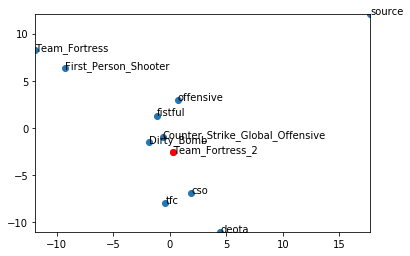

In [42]:
from src.vectorize import display_closestwords_pcascatterplot
display_closestwords_pcascatterplot(my_model.model, "Team_Fortress_2", dest="game")

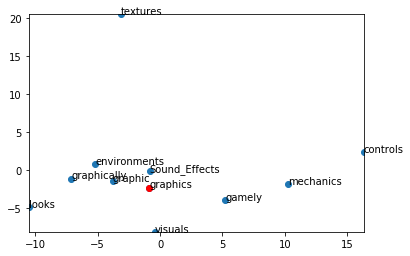

In [43]:
display_closestwords_pcascatterplot(my_model.model, "graphics", dest="feature")

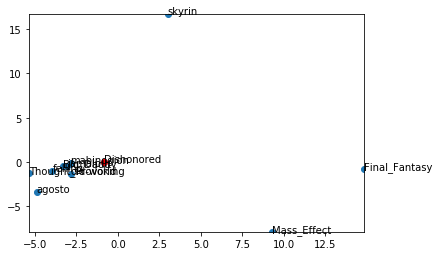

In [44]:
display_closestwords_pcascatterplot(my_model.model, "Dishonored", dest="game")

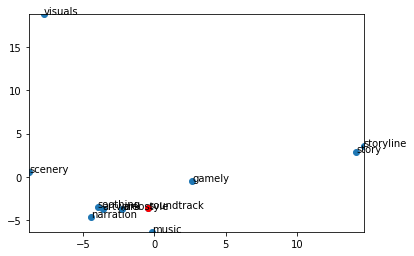

In [45]:
display_closestwords_pcascatterplot(my_model.model, "soundtrack", dest="feature")

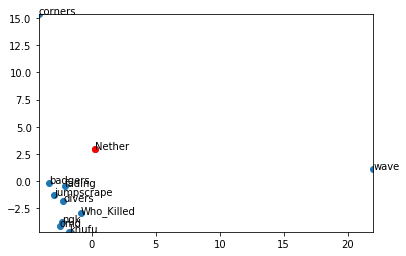

In [46]:
display_closestwords_pcascatterplot(my_model.model, "Nether", dest="game")